# Import Libraries

In [2]:
# EDA - Data Cleaning
import pandas as pd
import numpy as np
import missingno
from collections import Counter
import math

# EDA - Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# logistic regression model
import statsmodels.api as sm 

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', 100)

# Import re module to use regular expression
import re

# Defined Functions

In [3]:
def nulls_review(df, df2):
    print('fund shape before: ', df.shape)
    nulls = pd.DataFrame(df2.isnull().sum().sort_values(ascending = False), columns=['Amount'])
    nulls = nulls.loc[nulls['Amount'] == len(df2.index)]
    nulls.index.name='Columns With Missing Values'
    print('Number of columns with 100% null values = ', len(nulls.index))
    drop_cols = list(nulls.index)
    df.drop(columns=drop_cols, inplace=True)
    print('fund shape after: ', df.shape)
    
# Output any correlation values over 0.65 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X, threshold):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > threshold:
            print(index,value)
            
# Declare the filter function
def Filter(datalist, filt):
    # Search data based on regular expression in the list
    return [val for val in datalist
        if re.search(r''+filt, val)]

# Load in Datasets

In [4]:
#Load in Fundamentals dataset
fund_dtypes = {'gvkey':'str', 'ggroup':'str', 'gind':'str', 'gsector':'str', 'gsubind':'str', 'naics':'str', 'priusa':'str', 
               'sic':'str', 'stko':'str', 'upd':'str', 'spcseccd':'str', 'spcindcd':'str'}

fund = pd.read_csv('../01_data/01_original/Fundamentals_CR.csv', dtype=fund_dtypes, skipinitialspace = True)
fund = fund.replace(' ', np.nan)
print(f'Fundamentals dataset shape: {fund.shape}')

c = fund.select_dtypes(np.number).columns
fund[c] = fund[c].fillna(0)

#Establish GICS Reference Table
gic_ref = pd.DataFrame({'gsector': ['20', '20', '20', '20', '20', 
                               '20', '20', '20', '20', '20'],
                   'GIC_Sector':['Industrials', 'Industrials', 'Industrials', 'Industrials', 'Industrials', 
                                'Industrials', 'Industrials', 'Industrials', 'Industrials', 'Industrials'],
                   
                   'ggroup':['2010', '2010', '2010', '2010', '2010', 
                             '2010', '2010', '2010', '2010', '2010'],
                   'GIC_Group':['Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods', 
                               'Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods'],
                   
                   'gind':['201010', '201020', '201030', '201040', '201040',
                           '201050', '201060', '201060', '201060', '201070'],
                   'GIC_Industry':['Aeorspace & Defense', 'Building Products', 'Construction & Engineering', 'Electrical Equipment','Electrical Equipment', 
                                   'Industrial Congolomerates', 'Machinery', 'Machinery', 'Machinery', 'Trading Companies & Distributors'],
                   
                   'gsubind':['20101010', '20102010', '20103010', '20104010', '20104020', 
                              '20105010', '20106010',  '20106015', '20106020', '20107010'],
                   'GIC_SubIndustry':['Aerospace & Defense', 'Building Products', 'Construction & Engineering', 'Electrical Components & Equipment', 
                                      'Heavy Electrical Equipment','Industrial Conglomerates', 'Construction & Farm Machinery & Heavy Trucks', 
                                      'Agricultural & Farm Machinery', 'Industrial Machinary', 'Trading Companies & Distributors']})


#Load in SCA Filings and Settlements Spreadsheet
sca = pd.read_excel('../01_data/01_original/SCA Filings and Settlements.xlsx', 
                    usecols=['FilingName', 'Exchange', 'Ticker', 'SettlementAmount'])
sca = sca.replace('#NULL!', np.nan)
#Grouping by Ticker and Filing name to aggregate the settlement amounts
sca = sca.groupby(by=['Ticker']).agg({'SettlementAmount':'sum'})
sca.reset_index(inplace=True)
print(f'SCA Filings and Settlements dataset shape: {sca.shape}')

Fundamentals dataset shape: (3974, 921)
SCA Filings and Settlements dataset shape: (1506, 2)


In [5]:
fund[fund['tic']=='CR']['teq']

239    993.03
240    993.03
241    822.06
242    822.06
243    927.38
244    927.38
245   1214.67
246   1214.67
Name: teq, dtype: float64

# Data Preparation

## Create SUMM_STD indicator columns

This step takes the row indicating whether the values from a company's filing are related to a standard filing or a restatement and generates value-specific columns for each. This essentially doubles the size of the columns, but provides a basis for upcoming steps that will use restatment variances as a potential indicator to predict if a company is to have a securities-related suit filed.

In [6]:
#Engineer table to isolate out SUMM_STD and STD values by gvkey and datadate
fund_ind = fund[['gvkey', 'datadate', 'datafmt', ]].drop_duplicates()
fund_ind['datafmt1'] = fund_ind['datafmt']
fund_ind1 = fund_ind.set_index(['datafmt', 'gvkey', 'datadate']).unstack(['datafmt'])
fund_ind1.reindex(columns=sorted(fund_ind1.columns, key=lambda x: x[::-1]))
fund_ind1.columns = ['{}_{}'.format(t, v) for v,t in fund_ind1.columns]
fund_ind1.reset_index(inplace=True)

#Establish a Restatement_Flag column as an indicator if a restatement occured during that quarter
fund_ind1.loc[fund_ind1['SUMM_STD_datafmt1'].notnull(), 'restatementflag'] = 1
fund_ind1['restatementflag'].fillna(0, inplace=True)
fund_ind1['restatementflag'] = fund_ind1['restatementflag'].astype(str)
fund_ind1

#Join the indicator_flag to the original fund dataset
df = pd.merge(fund, fund_ind1[['gvkey', 'datadate', 'restatementflag']], left_on=['gvkey', 'datadate'], right_on =['gvkey', 'datadate'])

In [7]:
fund_ind = fund[['gvkey', 'datadate', 'datafmt']].drop_duplicates()
fund_ind['datafmt1'] = fund_ind['datafmt']
fund_ind1 = fund_ind.set_index(['datafmt', 'gvkey', 'datadate']).unstack(['datafmt'])
fund_ind1.reindex(columns=sorted(fund_ind1.columns, key=lambda x: x[::-1]))
fund_ind1.columns = ['{}_{}'.format(t, v) for v,t in fund_ind1.columns]
fund_ind1.reset_index(inplace=True)
fund_ind1

,gvkey,datadate,STD_datafmt1,SUMM_STD_datafmt1
0,10008,6/30/2010,STD,SUMM_STD
1,10008,6/30/2011,STD,SUMM_STD
2,10008,6/30/2012,STD,SUMM_STD
3,10008,6/30/2013,STD,SUMM_STD
4,100095,12/31/2010,STD,NaN
...,...,...,...,...
2052,9778,12/31/2013,STD,SUMM_STD
2053,9922,6/30/2010,STD,SUMM_STD
2054,9922,6/30/2011,STD,SUMM_STD
2055,9922,6/30/2012,STD,SUMM_STD


## Initial Column Removal Steps

Reviewed iniital columns that are predominantly blank or unusable for this analysis.

In [8]:
#Review the columns with null values in the dataset
null_std = fund[fund['datafmt']=='STD']
nulls_review(fund, null_std)

fund shape before:  (3974, 921)
Number of columns with 100% null values =  0
fund shape after:  (3974, 921)


In [9]:
print('Below is the number of rows in which a restatement occured for a particular entity:')
# fund_ind1[fund_ind1['SUMM_STD_datafmt1'].notnull()].STD_datafmt1.value_counts(dropna=False)
bef = len(fund)
aft = len(fund_ind1)
print(bef-aft, ' out of ',bef,' columns = ', (1919/3974), '%')

Below is the number of rows in which a restatement occured for a particular entity:
1917  out of  3974  columns =  0.4828887770508304 %


In [10]:
print('fund shape before: ', fund.shape)

#The below columns have been dropped due to no confirmed value (i.e., all values = 0 or just have 1 category associated, etc.)
fund_col_drop1 = ['prican' ,'prirow' ,'priusa' ,'apdedate' ,'pdate' ,'addzip' ,'fdate' ,'phone' ,'fax' ,'add1', 'busdesc', 'add3' ,'consol' ,'popsrc' ,
                     'incorp' ,'add4' ,'acctchg' ,'bspr' ,'county' ,'indfmt' ,'add2' ,'stalt' ,'loc' ,'curcd' ,'weburl' ,'final',
                     'acchg' ,'acdo' ,'aldo' ,'aocisecgl' ,'itcb' ,'txw' ,'xintopt' ,'xoptd' ,'xopteps']

fund_col_drop2 = ['conml', 'ein', 'city', 'sic', 'spcindcd', 'spcseccd', 'pddur', 'src', 'naics', 'acqmeth', 'acctstd', 'compst', 'curncd', 'state', 'spcsrc']

fund = fund.drop(columns=fund_col_drop1+fund_col_drop2)
print('Number of columns to drop = ', len(fund_col_drop1+fund_col_drop2))

print('fund shape after: ', fund.shape)

fund shape before:  (3974, 921)
Number of columns to drop =  50
fund shape after:  (3974, 871)


## Filter Restatement Rows and Select Columns

This step is a major column removal step. The logic used assesses if a column value is related to a restated filing. Essentially, for the purposes of this analysis, if a restatement has occured and the newly created restatment value columns generate no new values, they are removed from the dataset.

In [11]:
# Filter out columns who do not have any impacted restatement values
fund_summ_std = df[df['datafmt']=='SUMM_STD']
fund_summ_std_desc = fund_summ_std.describe(include='number').T
fund_summ_std_desc.reset_index(inplace=True)
fund_summ_std_desc = fund_summ_std_desc.loc[(fund_summ_std_desc['max'] != 0) | 
                                            (fund_summ_std_desc['min'] != 0)  | 
                                            (fund_summ_std_desc['index'].isin(['gla', 'dvt', 'invt', 'lt', 'revt', 'chech', 'dclc', 'dl', 'do', 'exre']))].sort_values('index', ascending=True)

In [12]:
fund_summ_std_desc

,index,count,mean,std,min,25%,50%,75%,max
71,at,1919.00,4569.26,33204.15,0.00,44.33,383.05,1933.43,745426.00
94,capx,1919.00,122.08,634.18,-0.04,0.74,10.80,52.19,15119.00
113,chech,1919.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
139,cogs,1919.00,1956.56,6021.65,0.00,21.70,250.84,1224.30,71244.00
147,cshfd,1919.00,109.61,559.80,0.00,10.29,28.19,72.57,10678.00
150,cshpri,1919.00,105.03,527.00,0.00,10.22,27.82,70.07,10661.00
868,dlrsn,1919.00,0.13,0.85,0.00,0.00,0.00,0.00,10.00
188,dltt,1919.00,1069.56,10264.84,0.00,0.03,18.49,420.68,312407.00
191,do,1919.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
193,dp,1919.00,99.25,492.98,0.00,0.95,12.58,59.35,11473.00


In [13]:
len(list(fund_summ_std_desc['index']))

42

In [14]:
#Keep the following columns where restatements have occured
fund_keep_obj_cols = ['gvkey', 'datadate', 'tic' ,'conm' ,'datafmt', 'restatementflag',
                      'ggroup' ,'gind' ,'gsector' ,'gsubind' ,'idbflag', 'upd']

#keeping all columns provided on the previous cell - will do a secondary review to confirm which columns to drop
fund_keep_numeric_cols = list(fund_summ_std_desc['index'])

# fund_keep_numeric_cols = ['at', 'capx', 'cogs', 'cshfd', 'cshpri', 'dltt', 'dp', 'emp', 'epsfi', 
#                           'epsfx', 'epspi', 'epspx', 'ib', 'ibmii', 'mii', 'ni', 'nopi', 'pi', 'ppent', 'reuna', 'sale', 'seq', 'teq', 
#                           'txt', 'wcap', 'xido', 'xint', 'xsga', 'dlrsn', 'fyrc']

# Reviewed the oclumns from the previous cell and determined the below columns are not needed
fund_numeric_cols_to_drop = ['dlrsn', 'epsfi', 'epsfx', 'epspx', 'fyear', 'fyrc', 'fyr', 'ib', 'upd', 'seq', 'cshpri','ibmii', 'mii', 'reuna', 'nopi', 'pi']

print('fund shape before: ', df.shape)
df = df[fund_keep_obj_cols + fund_keep_numeric_cols]
df = df.drop(columns=fund_numeric_cols_to_drop)
print('Number of columns kept = ', len(df.columns))
print('fund shape after: ', df.shape)

fund shape before:  (3974, 922)
Number of columns kept =  38
fund shape after:  (3974, 38)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 0 to 3973
Data columns (total 38 columns):
gvkey              3974 non-null object
datadate           3974 non-null object
tic                3974 non-null object
conm               3974 non-null object
datafmt            3974 non-null object
restatementflag    3974 non-null object
ggroup             3974 non-null object
gind               3974 non-null object
gsector            3974 non-null object
gsubind            3974 non-null object
idbflag            3974 non-null object
at                 3974 non-null float64
capx               3974 non-null float64
chech              3974 non-null float64
cogs               3974 non-null float64
cshfd              3974 non-null float64
dltt               3974 non-null float64
do                 3974 non-null float64
dp                 3974 non-null float64
dvt                3974 non-null float64
emp                3974 non-null float64
epspi              3974 non-null float64
ex

## Merging Additional Datasets - S&P GICS Industry

In [16]:
gic_ref

,gsector,GIC_Sector,ggroup,GIC_Group,gind,GIC_Industry,gsubind,GIC_SubIndustry
0,20,Industrials,2010,Capital Goods,201010,Aeorspace & Defense,20101010,Aerospace & Defense
1,20,Industrials,2010,Capital Goods,201020,Building Products,20102010,Building Products
2,20,Industrials,2010,Capital Goods,201030,Construction & Engineering,20103010,Construction & Engineering
3,20,Industrials,2010,Capital Goods,201040,Electrical Equipment,20104010,Electrical Components & Equipment
4,20,Industrials,2010,Capital Goods,201040,Electrical Equipment,20104020,Heavy Electrical Equipment
5,20,Industrials,2010,Capital Goods,201050,Industrial Congolomerates,20105010,Industrial Conglomerates
6,20,Industrials,2010,Capital Goods,201060,Machinery,20106010,Construction & Farm Machinery & Heavy Trucks
7,20,Industrials,2010,Capital Goods,201060,Machinery,20106015,Agricultural & Farm Machinery
8,20,Industrials,2010,Capital Goods,201060,Machinery,20106020,Industrial Machinary
9,20,Industrials,2010,Capital Goods,201070,Trading Companies & Distributors,20107010,Trading Companies & Distributors


In [17]:
print('Shape of dataset Before: ', df.shape)
col_to_merge = ['gind', 'gsubind']
df = pd.merge(df, gic_ref[['gind', 'gsubind', 'GIC_Industry', 'GIC_SubIndustry']], 
              left_on=col_to_merge, 
              right_on =col_to_merge)
df.drop(columns=col_to_merge+['ggroup', 'gsector'], inplace=True)
print('Shape of dataset After: ', df.shape)

Shape of dataset Before:  (3974, 38)
Shape of dataset After:  (3974, 36)


In [18]:
sca

,Ticker,SettlementAmount
0,AAC,0.00
1,AAI,0.00
2,AAMC,0.00
3,AAPL,16500000.00
4,AAVL,0.00
...,...,...
1501,ZQK,0.00
1502,ZRAN,0.00
1503,ZSTN,1700000.00
1504,ZUMZ,0.00


In [19]:
print(df.shape)
df = pd.merge(df, sca, how='left', left_on=['tic'], right_on=['Ticker'])
print(df.shape)

(3974, 36)
(3974, 38)


## Establish suitflag indicator column

In [20]:
df.loc[df['SettlementAmount'].notnull(), 'suitflag'] = 'Yes'
df.loc[df['suitflag'].isnull(), 'suitflag'] = 'No'

df.drop(columns=['Ticker'], inplace=True)

In [21]:
df.head(2)

,gvkey,datadate,tic,conm,datafmt,restatementflag,idbflag,at,capx,chech,cogs,cshfd,dltt,do,dp,dvt,emp,epspi,exre,gla,invt,lt,ni,pddur,ppent,revt,sale,src,teq,txt,wcap,xido,xint,xsga,GIC_Industry,GIC_SubIndustry,SettlementAmount,suitflag
0,1004,5/31/2010,AIR,AAR CORP,STD,1.0,D,1501.04,28.86,-33.13,1065.90,43.09,336.19,0.00,38.93,0.00,5.80,1.17,-0.12,-0.80,496.90,754.69,44.63,12,334.43,1352.15,1352.15,5,746.35,20.99,537.88,0.00,26.83,151.90,Aeorspace & Defense,Aerospace & Defense,nan,No
1,1004,5/31/2010,AIR,AAR CORP,SUMM_STD,1.0,D,1500.18,28.86,0.00,1065.90,43.09,336.19,0.00,38.93,0.00,0.00,1.17,0.00,0.00,0.00,0.00,44.63,12,329.21,0.00,1352.15,5,746.35,20.99,521.64,0.00,26.83,151.90,Aeorspace & Defense,Aerospace & Defense,nan,No


In [22]:
print('Suitflag valuecounts: \n', pd.value_counts(df['suitflag'], dropna=False))

Suitflag valuecounts: 
 No     3604
Yes     370
Name: suitflag, dtype: int64


# Creation of new variables using financial ratios

List of variables kept for this analysis include:

'at', 'capx', 'cogs', 'cshfd', 'cshpri', 'dltt', 'dp', 'emp', 'epspi','ibmii', 'mii', 'ni', 'nopi', 'pi', 'ppent', 'reuna', 'sale', 'seq', 'teq', 'txt', 'wcap', 'xido', 'xint', 'xsga'

'at', 'capx', 'cogs', 'cshfd','dltt', 'dp', 'emp', 'epspi', 'ni',  'ppent', 'sale', 'teq', 'txt', 'wcap', 'xido', 'xint', 'xsga', 'roa', 'roe'

    *SettlementAmount
    *Assets - Total
    *Capital Expenditures
    *Cost of Goods Sold
    *Common Shares Used to Calc Earnings Per Share - Fully Diluted
    *Long-Term Debt - Total
    *Depreciation and Amortization
    *Employees
    *Earnings Per Share (Basic) - Including Extraordinary Items
    *Net Income (Loss)
    *Property, Plant and Equipment - Total (Net)
    *Sales/Turnover (Net)
    *Stockholders Equity - Total
    *Working Capital
    *Interest and Related Expense - Total
    *Selling, General and Administrative Expense

Financial ratios created include:

    * Return on Equity (roe) = Net Income (ni) / Stockholders Equity - Total (teq)
    * Return on Assets (roa) = Net Income (ni) / Assets - Total (at)
    * Debt to Equity (dte) = Liabilites Total / Stockholders Equity - Total (teq)

In [23]:
df['roe'] = df['ni'] / df['teq']
df['roe'] = df['roe'].fillna(0)
df['roa'] = df['ni'] / df['at']
df['roa'] = df['roa'].fillna(0).replace({-np.inf:0, np.inf:0})
df['roa'] = df['roa'].replace({-np.inf:0, np.inf:0})
df['dte'] = df['lt'] / df['teq']
df['dte'] = df['dte'].fillna(0).replace({-np.inf:0, np.inf:0})

## Reengineer STD and SUMM_STD to create their own columns

In [24]:
main_col = ['gvkey', 'datadate', 'tic', 'conm', 'GIC_Industry', 'GIC_SubIndustry', 'suitflag', 'datafmt', 'restatementflag', 'idbflag']
       
support_col = [ 'at', 'capx', 'cogs', 'cshfd','dltt', 'dp', 'emp', 'epspi', 'ni',  'ppent', 'sale', 'teq', 'txt', 
               'wcap', 'xido', 'xint', 'xsga', 'roa', 'roe', 'gla', 'dvt', 'invt', 'dte', 'revt', 'chech',  'do', 'exre']

In [25]:
fund_ind = df[main_col+support_col].drop_duplicates()

fund_ind2 = fund_ind.set_index(main_col).unstack(['datafmt'])
fund_ind2.reindex(columns=sorted(fund_ind2.columns, key=lambda x: x[::-1]))
fund_ind2.columns = ['{}_{}'.format(t, v) for v,t in fund_ind2.columns]
fund_ind2.reset_index(inplace=True)
fund_ind2

fund = fund_ind2[fund_ind2.columns]
fund['restatementflag'] = fund['restatementflag'].astype(float).astype(int)

In [26]:
pd.value_counts(fund['suitflag'])

No     1866
Yes     191
Name: suitflag, dtype: int64

In [27]:
fund.head(2)

,gvkey,datadate,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,restatementflag,idbflag,STD_at,SUMM_STD_at,STD_capx,SUMM_STD_capx,STD_cogs,SUMM_STD_cogs,STD_cshfd,SUMM_STD_cshfd,STD_dltt,SUMM_STD_dltt,STD_dp,SUMM_STD_dp,STD_emp,SUMM_STD_emp,STD_epspi,SUMM_STD_epspi,STD_ni,SUMM_STD_ni,STD_ppent,SUMM_STD_ppent,STD_sale,SUMM_STD_sale,STD_teq,SUMM_STD_teq,STD_txt,SUMM_STD_txt,STD_wcap,SUMM_STD_wcap,STD_xido,SUMM_STD_xido,STD_xint,SUMM_STD_xint,STD_xsga,SUMM_STD_xsga,STD_roa,SUMM_STD_roa,STD_roe,SUMM_STD_roe,STD_gla,SUMM_STD_gla,STD_dvt,SUMM_STD_dvt,STD_invt,SUMM_STD_invt,STD_dte,SUMM_STD_dte,STD_revt,SUMM_STD_revt,STD_chech,SUMM_STD_chech,STD_do,SUMM_STD_do,STD_exre,SUMM_STD_exre
0,10008,6/30/2010,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,446.28,446.28,4.03,3.94,381.45,339.10,12.69,12.69,93.30,93.30,13.60,13.41,3.80,0.00,2.31,2.31,28.70,28.70,93.23,0.00,578.45,527.48,192.06,192.06,11.44,12.50,115.52,115.52,0.74,-1.65,3.62,3.62,138.77,127.16,0.06,0.06,0.15,0.15,0.00,0.00,2.54,0.00,69.55,0.00,1.32,0.00,578.45,0.00,24.65,0.00,0.74,0.00,1.76,0.00
1,10008,6/30/2011,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,474.90,474.90,6.05,5.92,417.90,374.70,12.75,12.75,46.50,46.50,14.16,13.27,4.00,0.00,2.84,2.83,35.37,35.37,96.33,87.09,633.75,581.37,245.61,245.61,13.96,14.92,92.41,92.41,-0.78,-2.66,2.11,2.11,148.73,137.81,0.07,0.07,0.14,0.14,0.00,0.00,2.95,0.00,83.58,0.00,0.93,0.00,633.75,0.00,-19.22,0.00,-0.78,0.00,1.91,0.00


In [28]:
fund['datadate'] = pd.to_datetime(fund['datadate'])
fund['most_recent_date'] = fund.groupby(['tic'])['datadate'].transform('max')
fund['most_recent_date'] = pd.to_datetime(fund['most_recent_date'])

In [29]:
num_col = ['at', 'capx', 'cogs', 'cshfd',  'dltt', 'dp', 'emp','epspi', 
           'ni', 'ppent', 'sale', 'teq', 'txt', 'wcap', 
           'xido', 'xint', 'xsga', 'roa', 'roe', 'gla', 'dvt', 'invt', 
           'dte', 'revt', 'chech',  'do', 'exre']

In [30]:
for ea in range(len(num_col)):
    fund['SUMM_STD_'+num_col[ea]].replace({0:np.nan}, inplace=True)

In [31]:
for ea in range(len(num_col)):
    #create a variance column for all numeric columns
    fund[num_col[ea]+'_Variance'] = fund['SUMM_STD_'+num_col[ea]] - fund['STD_'+num_col[ea]]
    #convert all null values for variance and SUMM_STD columns, which consist of only columns with no restatment (i.e. restatementflag = 'N')
    fund[num_col[ea]+'_Variance'].replace(np.nan, 0, inplace=True)
    #drop all 'SUMM_STD' columns; only using originally stated values and variances of restatements for this analysis
    fund.drop(columns=['SUMM_STD_'+num_col[ea]], inplace=True)

In [32]:
df = fund[fund.columns]

In [33]:
df.loc[(df['gvkey']=='10008')]

,gvkey,datadate,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,restatementflag,idbflag,STD_at,STD_capx,STD_cogs,STD_cshfd,STD_dltt,STD_dp,STD_emp,STD_epspi,STD_ni,STD_ppent,STD_sale,STD_teq,STD_txt,STD_wcap,STD_xido,STD_xint,STD_xsga,STD_roa,STD_roe,STD_gla,STD_dvt,STD_invt,STD_dte,STD_revt,STD_chech,STD_do,STD_exre,most_recent_date,at_Variance,capx_Variance,cogs_Variance,cshfd_Variance,dltt_Variance,dp_Variance,emp_Variance,epspi_Variance,ni_Variance,ppent_Variance,sale_Variance,teq_Variance,txt_Variance,wcap_Variance,xido_Variance,xint_Variance,xsga_Variance,roa_Variance,roe_Variance,gla_Variance,dvt_Variance,invt_Variance,dte_Variance,revt_Variance,chech_Variance,do_Variance,exre_Variance
0,10008,2010-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,446.28,4.03,381.45,12.69,93.30,13.60,3.80,2.31,28.70,93.23,578.45,192.06,11.44,115.52,0.74,3.62,138.77,0.06,0.15,0.00,2.54,69.55,1.32,578.45,24.65,0.74,1.76,2013-06-30,0.00,-0.09,-42.35,0.00,0.00,-0.19,0.00,0.00,0.00,0.00,-50.97,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,10008,2011-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,474.90,6.05,417.90,12.75,46.50,14.16,4.00,2.84,35.37,96.33,633.75,245.61,13.96,92.41,-0.78,2.11,148.73,0.07,0.14,0.00,2.95,83.58,0.93,633.75,-19.22,-0.78,1.91,2013-06-30,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,0.96,0.00,-1.88,0.00,-10.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,10008,2012-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,479.81,9.94,412.67,12.79,50.00,13.49,3.90,2.47,30.91,82.56,634.64,242.91,15.91,132.49,-16.00,2.28,146.53,0.06,0.13,0.00,3.47,73.08,0.98,634.64,40.34,-16.00,-2.37,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10008,2013-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,510.57,14.15,458.07,12.78,50.07,15.55,4.40,3.57,44.85,95.02,701.26,290.99,15.91,139.83,-0.47,2.47,159.07,0.09,0.15,0.00,3.98,84.96,0.75,701.26,-3.69,-0.47,-0.26,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Another Missing Data Review Checkpoint

In [34]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
STD_dte,2
STD_xsga,2
STD_sale,2
STD_teq,2
STD_txt,2
STD_wcap,2
STD_xido,2
STD_xint,2
STD_roa,2


In [35]:
df

,gvkey,datadate,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,restatementflag,idbflag,STD_at,STD_capx,STD_cogs,STD_cshfd,STD_dltt,STD_dp,STD_emp,STD_epspi,STD_ni,STD_ppent,STD_sale,STD_teq,STD_txt,STD_wcap,STD_xido,STD_xint,STD_xsga,STD_roa,STD_roe,STD_gla,STD_dvt,STD_invt,STD_dte,STD_revt,STD_chech,STD_do,STD_exre,most_recent_date,at_Variance,capx_Variance,cogs_Variance,cshfd_Variance,dltt_Variance,dp_Variance,emp_Variance,epspi_Variance,ni_Variance,ppent_Variance,sale_Variance,teq_Variance,txt_Variance,wcap_Variance,xido_Variance,xint_Variance,xsga_Variance,roa_Variance,roe_Variance,gla_Variance,dvt_Variance,invt_Variance,dte_Variance,revt_Variance,chech_Variance,do_Variance,exre_Variance
0,10008,2010-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,446.28,4.03,381.45,12.69,93.30,13.60,3.80,2.31,28.70,93.23,578.45,192.06,11.44,115.52,0.74,3.62,138.77,0.06,0.15,0.00,2.54,69.55,1.32,578.45,24.65,0.74,1.76,2013-06-30,0.00,-0.09,-42.35,0.00,0.00,-0.19,0.00,0.00,0.00,0.00,-50.97,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,10008,2011-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,474.90,6.05,417.90,12.75,46.50,14.16,4.00,2.84,35.37,96.33,633.75,245.61,13.96,92.41,-0.78,2.11,148.73,0.07,0.14,0.00,2.95,83.58,0.93,633.75,-19.22,-0.78,1.91,2013-06-30,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,0.96,0.00,-1.88,0.00,-10.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,10008,2012-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,479.81,9.94,412.67,12.79,50.00,13.49,3.90,2.47,30.91,82.56,634.64,242.91,15.91,132.49,-16.00,2.28,146.53,0.06,0.13,0.00,3.47,73.08,0.98,634.64,40.34,-16.00,-2.37,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10008,2013-06-30,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,1,D,510.57,14.15,458.07,12.78,50.07,15.55,4.40,3.57,44.85,95.02,701.26,290.99,15.91,139.83,-0.47,2.47,159.07,0.09,0.15,0.00,3.98,84.96,0.75,701.26,-3.69,-0.47,-0.26,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,100095,2010-12-31,BZLFY,BUNZL PLC,Trading Companies & Distributors,Trading Companies & Distributors,No,0,B,4091.81,36.02,6921.63,65.18,1064.36,106.20,12.37,3.79,244.73,181.78,7433.72,1225.82,101.89,472.53,0.00,52.95,0.00,0.06,0.20,0.00,101.74,741.89,2.34,7433.72,49.10,0.00,2.77,2013-12-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,9778,2013-12-31,SNA,SNAP-ON INC,Machinery,Industrial Machinary,No,1,D,4110.00,70.60,1502.50,59.10,885.60,76.70,11.30,6.02,350.30,392.50,3237.50,2130.40,166.70,1080.80,0.00,56.10,1065.70,0.09,0.16,0.00,92.00,434.40,0.93,3237.50,3.10,0.00,-1.30,2013-12-31,0.00,0.00,0.00,0.00,-26.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2053,9922,2010-06-30,SPA,SPARTON CORP,Aeorspace & Defense,Aerospace & Defense,No,1,D,119.86,1.53,145.61,9.97,1.80,1.46,0.70,0.75,7.44,8.92,173.98,64.27,-1.92,37.73,0.00,0.84,18.20,0.06,0.12,0.13,0.00,26.51,0.86,173.98,-5.67,0.00,0.00,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2054,9922,2011-06-30,SPA,SPARTON CORP,Aeorspace & Defense,Aerospace & Defense,No,1,D,122.61,3.18,169.12,10.26,1.67,1.61,0.87,0.73,7.46,11.39,203.35,75.05,-11.40,51.32,0.00,0.71,21.35,0.06,0.10,0.00,0.00,38.75,0.63,203.35,-6.04,0.00,0.00,2013

In [36]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
STD_dte,2
STD_xsga,2
STD_sale,2
STD_teq,2
STD_txt,2
STD_wcap,2
STD_xido,2
STD_xint,2
STD_roa,2


# Split up dataset groupings

In [37]:
# Drop rows where no originally filed values have occured; in this case only restated values are present
print('The below 2 rows below contain null values where a company has restated values present but no originally stated values. They will be removed from this dataset.\n')
null_val = fund_ind1[fund_ind1['STD_datafmt1'].isnull()]
print(null_val)

df = df.loc[~(df['gvkey'].isin(list(null_val.gvkey)) & (df['STD_at'].isnull()))]

The below 2 rows below contain null values where a company has restated values present but no originally stated values. They will be removed from this dataset.

      gvkey   datadate STD_datafmt1 SUMM_STD_datafmt1
340  143748  3/31/2010          NaN          SUMM_STD
979  186654  2/28/2010          NaN          SUMM_STD


In [38]:
df.describe(include='all').T[['count']]

,count
gvkey,2055
datadate,2055
tic,2055
conm,2055
GIC_Industry,2055
GIC_SubIndustry,2055
suitflag,2055
restatementflag,2055.00
idbflag,2055
STD_at,2055.00


## Dataset1: Keep only Categorical Variables (Using Most Recent Logic)

In [39]:
#List of categorical variables kept for next steps in analysis
col1 = ['tic', 'conm', 'GIC_Industry', 'GIC_SubIndustry', 'suitflag', 'idbflag', 'restatementflag']
fund_categorical = df.loc[df['datadate']==df['most_recent_date']][['gvkey']+col1].set_index('gvkey')

for ea in range(len(col1)):
    df.drop(columns=[col1[ea]], inplace=True)
    
fund_categorical

,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag
gvkey,,,,,,,
10008,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,D,1
100095,BZLFY,BUNZL PLC,Trading Companies & Distributors,Trading Companies & Distributors,No,B,0
10016,SWK,STANLEY BLACK & DECKER INC,Machinery,Industrial Machinary,No,D,1
10030,SCX,STARRETT (L.S.) CO -CL A,Machinery,Industrial Machinary,No,D,1
1004,AIR,AAR CORP,Aeorspace & Defense,Aerospace & Defense,No,D,1
...,...,...,...,...,...,...,...
9619,SVT,SERVOTRONICS INC,Electrical Equipment,Electrical Components & Equipment,No,D,1
9698,SIF,SIFCO INDUSTRIES,Aeorspace & Defense,Aerospace & Defense,No,D,1
9771,AOS,SMITH (A O) CORP,Building Products,Building Products,No,D,1


In [40]:
print('Suitflag valuecounts: \n', pd.value_counts(fund_categorical['suitflag'], dropna=False))

Suitflag valuecounts: 
 No     521
Yes     57
Name: suitflag, dtype: int64


## Dataset2: Max/ Min Variance Values

### Max

In [41]:
print('Number Columns include: ', num_col)

Number Columns include:  ['at', 'capx', 'cogs', 'cshfd', 'dltt', 'dp', 'emp', 'epspi', 'ni', 'ppent', 'sale', 'teq', 'txt', 'wcap', 'xido', 'xint', 'xsga', 'roa', 'roe', 'gla', 'dvt', 'invt', 'dte', 'revt', 'chech', 'do', 'exre']


In [42]:
df

,gvkey,datadate,STD_at,STD_capx,STD_cogs,STD_cshfd,STD_dltt,STD_dp,STD_emp,STD_epspi,STD_ni,STD_ppent,STD_sale,STD_teq,STD_txt,STD_wcap,STD_xido,STD_xint,STD_xsga,STD_roa,STD_roe,STD_gla,STD_dvt,STD_invt,STD_dte,STD_revt,STD_chech,STD_do,STD_exre,most_recent_date,at_Variance,capx_Variance,cogs_Variance,cshfd_Variance,dltt_Variance,dp_Variance,emp_Variance,epspi_Variance,ni_Variance,ppent_Variance,sale_Variance,teq_Variance,txt_Variance,wcap_Variance,xido_Variance,xint_Variance,xsga_Variance,roa_Variance,roe_Variance,gla_Variance,dvt_Variance,invt_Variance,dte_Variance,revt_Variance,chech_Variance,do_Variance,exre_Variance
0,10008,2010-06-30,446.28,4.03,381.45,12.69,93.30,13.60,3.80,2.31,28.70,93.23,578.45,192.06,11.44,115.52,0.74,3.62,138.77,0.06,0.15,0.00,2.54,69.55,1.32,578.45,24.65,0.74,1.76,2013-06-30,0.00,-0.09,-42.35,0.00,0.00,-0.19,0.00,0.00,0.00,0.00,-50.97,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,10008,2011-06-30,474.90,6.05,417.90,12.75,46.50,14.16,4.00,2.84,35.37,96.33,633.75,245.61,13.96,92.41,-0.78,2.11,148.73,0.07,0.14,0.00,2.95,83.58,0.93,633.75,-19.22,-0.78,1.91,2013-06-30,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,0.96,0.00,-1.88,0.00,-10.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,10008,2012-06-30,479.81,9.94,412.67,12.79,50.00,13.49,3.90,2.47,30.91,82.56,634.64,242.91,15.91,132.49,-16.00,2.28,146.53,0.06,0.13,0.00,3.47,73.08,0.98,634.64,40.34,-16.00,-2.37,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10008,2013-06-30,510.57,14.15,458.07,12.78,50.07,15.55,4.40,3.57,44.85,95.02,701.26,290.99,15.91,139.83,-0.47,2.47,159.07,0.09,0.15,0.00,3.98,84.96,0.75,701.26,-3.69,-0.47,-0.26,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,100095,2010-12-31,4091.81,36.02,6921.63,65.18,1064.36,106.20,12.37,3.79,244.73,181.78,7433.72,1225.82,101.89,472.53,0.00,52.95,0.00,0.06,0.20,0.00,101.74,741.89,2.34,7433.72,49.10,0.00,2.77,2013-12-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,9778,2013-12-31,4110.00,70.60,1502.50,59.10,885.60,76.70,11.30,6.02,350.30,392.50,3237.50,2130.40,166.70,1080.80,0.00,56.10,1065.70,0.09,0.16,0.00,92.00,434.40,0.93,3237.50,3.10,0.00,-1.30,2013-12-31,0.00,0.00,0.00,0.00,-26.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2053,9922,2010-06-30,119.86,1.53,145.61,9.97,1.80,1.46,0.70,0.75,7.44,8.92,173.98,64.27,-1.92,37.73,0.00,0.84,18.20,0.06,0.12,0.13,0.00,26.51,0.86,173.98,-5.67,0.00,0.00,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2054,9922,2011-06-30,122.61,3.18,169.12,10.26,1.67,1.61,0.87,0.73,7.46,11.39,203.35,75.05,-11.40,51.32,0.00,0.71,21.35,0.06,0.10,0.00,0.00,38.75,0.63,203.35,-6.04,0.00,0.00,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2055,9922,2012-06-30,144.56,4.24,183.70,10.21,1.54,1.81,0.87,0.93,9.51,14.26,223.58,82.49,5.08,59.35,0.00,0.70,23.52,0.07,0.12,0.08,0.00,35.10,0.75,223.58,22.40,0.00,0.00,2013-06-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [43]:
fund_perc_change = df[df.columns]

for ea in range(len(num_col)):
    #Rename numerical columns to indicate values use the most recent dates in dataset
    fund_perc_change.rename({num_col[ea]+'_Variance':num_col[ea]+'_Percent'}, axis='columns', inplace=True)
    fund_perc_change[num_col[ea]+'_Percent'] = fund_perc_change[num_col[ea]+'_Percent'] / fund_perc_change['STD_'+num_col[ea]]
    fund_perc_change[num_col[ea]+'_Percent'] = fund_perc_change[num_col[ea]+'_Percent'].round(decimals=2)
    
    fund_perc_change_max = fund_perc_change.groupby('gvkey').max()
    fund_perc_change_min = fund_perc_change.groupby('gvkey').min()

# # # # # Print the filter data
cols = fund_perc_change.columns
var_cols = Filter(cols, 'Percent')

fund_perc_change_max = fund_perc_change_max[var_cols]
fund_perc_change_min = fund_perc_change_min[var_cols]
fund_perc_change_max.fillna(0, inplace=True)
fund_perc_change_min.fillna(0, inplace=True)

fund_perc_change = fund_perc_change_max.join(fund_perc_change_min, lsuffix='_max', rsuffix='_min')
fund_perc_change

for ea in range(len(num_col)):
    fund_perc_change.loc[np.absolute(fund_perc_change[num_col[ea]+'_Percent_max']) >= np.absolute(fund_perc_change[num_col[ea]+'_Percent_min']), num_col[ea]+'_Variance'] = 'Max'
    fund_perc_change.loc[fund_perc_change[num_col[ea]+'_Variance'].isnull(), num_col[ea]+'_Variance'] = 'Min'
    fund_perc_change.loc[fund_perc_change[num_col[ea]+'_Variance']=='Max', num_col[ea]+'_PercentChange'] = fund_perc_change[num_col[ea]+'_Percent_max']
    fund_perc_change.loc[fund_perc_change[num_col[ea]+'_PercentChange'].isnull(), num_col[ea]+'_PercentChange'] = fund_perc_change[num_col[ea]+'_Percent_min']
    
cols = fund_perc_change.columns
var_cols = Filter(cols, 'PercentChange')
fund_perc_change = fund_perc_change[var_cols]
fund_perc_change.fillna(0, inplace=True)
fund_perc_change

,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,0.00,-0.02,-0.11,0.00,0.00,-0.06,0.00,0.00,0.00,-0.10,-0.09,0.00,0.09,0.00,-3.24,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,0.00,0.00,-0.10,0.00,0.00,0.10,0.01,0.00,-0.00,0.00,-0.11,0.00,-0.41,0.01,inf,-0.00,-0.08,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
10030,0.00,0.00,0.04,0.00,0.00,0.00,0.00,1.67,1.69,0.00,0.00,-0.01,-2.54,0.00,0.00,-0.66,0.04,1.69,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
1004,-0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.02,0.00,-0.05,-0.03,-0.00,0.00,0.05,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.00,0.00,-0.10,0.00,0.00,-0.14,0.00,0.00,0.00,0.00,-0.04,0.00,0.70,0.00,-inf,-0.14,-0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
9698,0.00,-0.17,-0.16,0.00,0.00,-0.10,0.00,0.00,0.00,-0.12,-0.18,0.00,0.00,0.00,inf,0.00,-0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
9771,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,-0.50,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [44]:
fund_max_values = df.groupby('gvkey').max()

for ea in range(len(num_col)):
    #Rename numerical columns to indicate values use the most recent dates in dataset
    fund_max_values.rename({'STD_'+num_col[ea]:'Max_'+num_col[ea]}, axis='columns', inplace=True)
    fund_max_values.rename({num_col[ea]+'_Variance':'Max_'+num_col[ea]+'_Variance'}, axis='columns', inplace=True)

# Print the filter data
cols = fund_max_values.columns
var_cols = Filter(cols, 'Variance')

fund_max_values = fund_max_values[var_cols]
fund_max_values

,Max_at_Variance,Max_capx_Variance,Max_cogs_Variance,Max_cshfd_Variance,Max_dltt_Variance,Max_dp_Variance,Max_emp_Variance,Max_epspi_Variance,Max_ni_Variance,Max_ppent_Variance,Max_sale_Variance,Max_teq_Variance,Max_txt_Variance,Max_wcap_Variance,Max_xido_Variance,Max_xint_Variance,Max_xsga_Variance,Max_roa_Variance,Max_roe_Variance,Max_gla_Variance,Max_dvt_Variance,Max_invt_Variance,Max_dte_Variance,Max_revt_Variance,Max_chech_Variance,Max_do_Variance,Max_exre_Variance
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,0.00,0.00,0.00,0.00,0.00,38.70,0.24,0.00,0.00,0.00,0.00,0.00,0.00,11.70,84.60,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10030,0.00,0.00,4.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,2.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1004,0.00,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.33,0.00,0.00,0.00,0.00,0.00,9.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9698,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9771,0.00,0.00,0.00,46.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Min

In [45]:
fund_min_values = df.groupby('gvkey').min()

for ea in range(len(num_col)):
    #Rename numerical columns to indicate values use the most recent dates in dataset
    fund_min_values.rename({'STD_'+num_col[ea]:'Min_'+num_col[ea]}, axis='columns', inplace=True)
    fund_min_values.rename({num_col[ea]+'_Variance':'Min_'+num_col[ea]+'_Variance'}, axis='columns', inplace=True)

# Print the filter data
cols = fund_min_values.columns
var_cols = Filter(cols, 'Variance')

fund_min_values = fund_min_values[var_cols]
fund_min_values

,Min_at_Variance,Min_capx_Variance,Min_cogs_Variance,Min_cshfd_Variance,Min_dltt_Variance,Min_dp_Variance,Min_emp_Variance,Min_epspi_Variance,Min_ni_Variance,Min_ppent_Variance,Min_sale_Variance,Min_teq_Variance,Min_txt_Variance,Min_wcap_Variance,Min_xido_Variance,Min_xint_Variance,Min_xsga_Variance,Min_roa_Variance,Min_roe_Variance,Min_gla_Variance,Min_dvt_Variance,Min_invt_Variance,Min_dte_Variance,Min_revt_Variance,Min_chech_Variance,Min_do_Variance,Min_exre_Variance
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,0.00,0.00,-2.39,0.00,-11.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,0.00,0.00,-641.40,0.00,0.00,0.00,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,0.00,-15.30,-0.20,-194.20,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10030,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,0.00,-0.03,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1004,-0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,0.00,0.00,-1.78,-16.24,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.00,0.00,-1.03,-0.01,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9698,0.00,-0.59,-15.29,0.00,0.00,-0.64,0.00,0.00,0.00,-3.76,-22.21,0.00,0.00,-0.05,0.00,0.00,-5.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9771,-1.40,0.00,0.00,0.00,0.00,0.00,0.00,-3.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Greater of the ABS for Min and Max

In [46]:
fund_min_max = fund_max_values.join(fund_min_values)
fund_min_max

,Max_at_Variance,Max_capx_Variance,Max_cogs_Variance,Max_cshfd_Variance,Max_dltt_Variance,Max_dp_Variance,Max_emp_Variance,Max_epspi_Variance,Max_ni_Variance,Max_ppent_Variance,Max_sale_Variance,Max_teq_Variance,Max_txt_Variance,Max_wcap_Variance,Max_xido_Variance,Max_xint_Variance,Max_xsga_Variance,Max_roa_Variance,Max_roe_Variance,Max_gla_Variance,Max_dvt_Variance,Max_invt_Variance,Max_dte_Variance,Max_revt_Variance,Max_chech_Variance,Max_do_Variance,Max_exre_Variance,Min_at_Variance,Min_capx_Variance,Min_cogs_Variance,Min_cshfd_Variance,Min_dltt_Variance,Min_dp_Variance,Min_emp_Variance,Min_epspi_Variance,Min_ni_Variance,Min_ppent_Variance,Min_sale_Variance,Min_teq_Variance,Min_txt_Variance,Min_wcap_Variance,Min_xido_Variance,Min_xint_Variance,Min_xsga_Variance,Min_roa_Variance,Min_roe_Variance,Min_gla_Variance,Min_dvt_Variance,Min_invt_Variance,Min_dte_Variance,Min_revt_Variance,Min_chech_Variance,Min_do_Variance,Min_exre_Variance
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,0.00,0.00,-2.39,0.00,-11.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,0.00,0.00,0.00,0.00,0.00,38.70,0.24,0.00,0.00,0.00,0.00,0.00,0.00,11.70,84.60,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-641.40,0.00,0.00,0.00,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,0.00,-15.30,-0.20,-194.20,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10030,0.00,0.00,4.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,2.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,0.00,-0.03,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1004,0.00,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.33,0.00,0.00,0.00,0.00,0.00,9.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,0.00,0.00,-1.78,-16.24,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.00,0.00,-1.03,-0.01,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9698,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.59,-15.29,0.00,0.00,-0.64,0.00,0.00,0.00,-3.76,-22.21,0.00,0.00,-0.05,0.00,0.00,-5.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9771,0.00,0.00,0.00,46.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.40,0.00,0.00,0.00,0.00,0.00,0.00,-3.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


To better assess variability, I am going to take the ABS of the Min and Max. Then I am going to select the greater of the two to isolate the potential volatility of the two.

In [47]:
num_col = ['at', 'capx', 'cogs', 'cshfd',  'dltt', 'dp', 'emp','epspi', 
           'ni', 'ppent', 'sale', 'teq', 'txt', 'wcap', 
           'xido', 'xint', 'xsga', 'roa', 'roe', 'gla', 'dvt', 'invt', 
           'dte', 'revt', 'chech',  'do', 'exre']

for ea in range(len(num_col)):

    fund_min_max.loc[np.absolute(fund_min_max['Max_'+num_col[ea]+'_Variance']) >= np.absolute(fund_min_max['Min_'+num_col[ea]+'_Variance']), num_col[ea]+'_Variance'] = 'Max'
    fund_min_max.loc[fund_min_max[num_col[ea]+'_Variance'].isnull(), num_col[ea]+'_Variance'] = 'Min'
    fund_min_max.loc[fund_min_max[num_col[ea]+'_Variance']=='Max', 'Vol_'+num_col[ea]+'_Variance'] = fund_min_max['Max_'+num_col[ea]+'_Variance']
    fund_min_max.loc[fund_min_max['Vol_'+num_col[ea]+'_Variance'].isnull(), 'Vol_'+num_col[ea]+'_Variance'] = fund_min_max['Min_'+num_col[ea]+'_Variance']



# Print the filter data
cols = fund_min_max.columns
var_cols = Filter(cols, 'Vol_')

fund_min_max = fund_min_max[var_cols]
fund_min_max = fund_min_max.fillna(0)

drop_col = ['gla', 'dvt', 'invt', 'dte', 'revt', 'chech',  'do', 'exre']

for ea in range(len(drop_col)):
    fund_min_max.drop(columns='Vol_'+drop_col[ea]+'_Variance', inplace=True)
    
fund_min_max

,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance
gvkey,,,,,,,,,,,,,,,,,,,
10008,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00
100095,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,0.00,0.00,-641.40,0.00,0.00,38.70,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,11.70,84.60,-0.20,-194.20,-0.00,-0.00
10030,0.00,0.00,4.63,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,2.59,-0.03,-0.04
1004,-0.86,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,29.33,0.00,-1.78,-16.24,0.00,-0.00,9.10,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.47,0.00,-1.03,-0.01,-0.28,0.00,0.00
9698,0.00,-0.59,-15.29,0.00,0.00,-0.64,0.00,0.00,0.00,-3.76,-22.21,0.00,0.01,-0.05,0.24,0.00,-5.94,0.00,0.00
9771,-1.40,0.00,0.00,46.57,0.00,0.00,0.00,-3.32,0.00,0.00,0.00,0.00,0.00,7.60,0.00,0.00,0.00,0.00,0.00


## Dataset3: StandardDev

In [48]:
fund_std_values = df.groupby('gvkey').std()

 
for ea in range(len(num_col)):
    #Rename numerical columns to indicate values use the most recent dates in dataset
    fund_std_values.rename({'STD_'+num_col[ea]:'StdDev_'+num_col[ea]}, axis='columns', inplace=True)
    fund_std_values.rename({num_col[ea]+'_Variance':'StdDev_'+num_col[ea]+'_Variance'}, axis='columns', inplace=True)

fund_std_values = fund_std_values[fund_std_values.columns[0:19]]
fund_std_values

,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe
gvkey,,,,,,,,,,,,,,,,,,,
10008,26.33,4.47,31.46,0.05,22.28,0.95,0.26,0.56,7.15,6.28,50.24,40.43,2.12,21.06,7.94,0.69,8.37,0.01,0.01
100095,528.74,3.98,1073.88,132.24,197.78,14.75,0.87,1.62,68.68,11.29,1164.66,157.64,15.70,116.98,0.00,7.65,0.00,0.01,0.03
10016,572.43,90.24,738.29,8.89,415.92,38.61,5.77,1.71,290.82,135.86,1112.00,165.03,21.51,582.18,224.89,21.03,208.69,0.02,0.04
10030,21.36,1.76,17.38,0.06,15.22,0.67,0.10,0.62,4.14,2.51,24.15,12.42,3.13,15.18,0.00,0.30,7.44,0.02,0.03
1004,336.77,45.47,296.49,1.35,181.67,29.80,0.38,0.27,11.77,52.12,367.01,72.52,6.01,63.72,1.66,6.69,23.82,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,0.84,0.48,1.30,0.07,1.58,0.03,0.02,0.54,1.05,0.41,1.78,1.08,0.28,1.53,0.66,0.01,0.31,0.04,0.05
9698,18.58,1.67,13.13,0.04,9.01,2.07,0.13,0.38,2.07,4.92,17.97,10.34,0.59,4.82,0.24,0.19,2.00,0.02,0.02
9771,123.34,20.85,134.66,23.18,117.20,8.32,0.43,2.13,83.38,55.75,286.92,188.96,24.43,143.74,92.73,1.77,87.45,0.03,0.08


In [49]:
fund_df = fund_categorical.join(fund_min_max)
# fund_df = fund_df.join(fund_mean_values)
fund_df = fund_df.join(fund_std_values)
fund_df = fund_df.join(fund_perc_change)

In [50]:
fund_df

,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,D,1,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,26.33,4.47,31.46,0.05,22.28,0.95,0.26,0.56,7.15,6.28,50.24,40.43,2.12,21.06,7.94,0.69,8.37,0.01,0.01,0.00,-0.02,-0.11,0.00,0.00,-0.06,0.00,0.00,0.00,-0.10,-0.09,0.00,0.09,0.00,-3.24,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,BZLFY,BUNZL PLC,Trading Companies & Distributors,Trading Companies & Distributors,No,B,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,528.74,3.98,1073.88,132.24,197.78,14.75,0.87,1.62,68.68,11.29,1164.66,157.64,15.70,116.98,0.00,7.65,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,SWK,STANLEY BLACK & DECKER INC,Machinery,Industrial Machinary,No,D,1,0.00,0.00,-641.40,0.00,0.00,38.70,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,11.70,84.60,-0.20,-194.20,-0.00,-0.00,572.43,90.24,738.29,8.89,415.92,38.61,5.77,1.71,290.82,135.86,1112.00,165.03,21.51,582.18,224.89,21.03,208.69,0.02,0.04,0.00,0.00,-0.10,0.00,0.00,0.10,0.01,0.00,-0.00,0.00,-0.11,0.00,-0.41,0.01,inf,-0.00,-0.08,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
10030,SCX,STARRETT (L.S.) CO -CL A,Machinery,Industrial Machinary,No,D,1,0.00,0.00,4.63,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,2.59,-0.03,-0.04,21.36,1.76,17.38,0.06,15.22,0.67,0.10,0.62,4.14,2.51,24.15,12.42,3.13,15.18,0.00,0.30,7.44,0.02,0.03,0.00,0.00,0.04,0.00,0.00,0.00,0.00,1.67,1.69,0.00,0.00,-0.01,-2.54,0.00,0.00,-0.66,0.04,1.69,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
1004,AIR,AAR CORP,Aeorspace & Defense,Aerospace & Defense,No,D,1,-0.86,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,29.33,0.00,-1.78,-16.24,0.00,-0.00,9.10,0.00,0.00,336.77,45.47,296.49,1.35,181.67,29.80,0.38,0.27,11.77,52.12,367.01,72.52,6.01,63.72,1.66,6.69,23.82,0.01,0.01,-0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.02,0.00,-0.05,-0.03,-0.00,0.00,0.05,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,SVT,SERVOTRONICS INC,Electrical Equipment,Electrical Components & Equipment,No,D,1,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.47,0.00,-1.03,-0.01,-0.28,0.00,0.00,0.84,0.48,1.30,0.07,1.58,0.03,0.02,0.54,1.05,0.41,1.78,1.08,0.28,1.53,0.66,0.01,0.31,0.04,0.05,0.00,0.00,-0.10,0.00,0.00,-0.14,0.00,0.00,0.00,0.00,-0.04,0.00,

# Filter out sub-industries from population

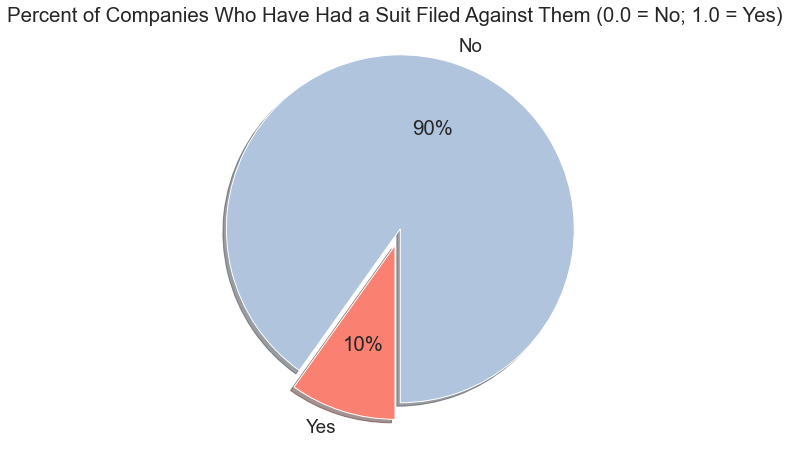

In [51]:
# Data to plot for the % of target variable
sns.set(font_scale = 1.7)
labels =fund_df['suitflag'].value_counts(sort = True).index
sizes = fund_df['suitflag'].value_counts(sort = True)
colors = ["lightsteelblue","salmon"]
explode = (0.1,0)  # explode 1st slice
 
rcParams['figure.figsize'] = 8,8
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=True, startangle=270,)
plt.title('Percent of Companies Who Have Had a Suit Filed Against Them (0.0 = No; 1.0 = Yes)')
plt.show()

In [52]:
pd.value_counts(fund_df['suitflag'])

No     521
Yes     57
Name: suitflag, dtype: int64

In [53]:
pd.crosstab(fund_df.restatementflag, fund_df.suitflag)

suitflag,No,Yes
restatementflag,,
0,43,5
1,478,52


In [54]:
len(fund_df[fund_df['suitflag']=='No']['suitflag'])

521

In [55]:
y = len(fund_df[fund_df['suitflag']=='Yes']['suitflag'])
n = len(fund_df[fund_df['suitflag']=='No']['suitflag'])

print( round((y / (y+n))*100,3), '% of the total population has had a suit file against them.' )

9.862 % of the total population has had a suit file against them.


In [56]:
fund_df[fund_df['tic']=='CR'].head(1)

,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3580,CR,CRANE CO,Machinery,Industrial Machinary,No,D,1,0.00,0.00,-36.94,0.00,0.00,-2.66,0.00,0.00,0.00,0.00,-45.50,0.00,-1.99,0.00,3.70,0.00,-9.95,0.00,0.00,381.14,5.66,114.02,0.54,175.13,2.01,0.48,1.57,90.48,15.27,178.98,165.94,49.02,89.75,10.82,0.29,19.77,0.03,0.09,0.00,0.00,-0.03,0.00,0.00,-0.05,0.00,0.00,0.00,0.00,-0.02,0.00,0.33,0.00,inf,0.00,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00


In [57]:
pd.crosstab(fund_df.GIC_Industry, fund_df.suitflag)

suitflag,No,Yes
GIC_Industry,,
Aeorspace & Defense,83,9
Building Products,43,3
Construction & Engineering,41,9
Electrical Equipment,102,17
Industrial Congolomerates,11,2
Machinery,177,15
Trading Companies & Distributors,64,2


In [58]:
# fund_df = fund_df.loc[~fund_df['GIC_Industry'].isin(['Trading Companies & Distributors', 'Building Products'])]

In [59]:
num_col

['at',
 'capx',
 'cogs',
 'cshfd',
 'dltt',
 'dp',
 'emp',
 'epspi',
 'ni',
 'ppent',
 'sale',
 'teq',
 'txt',
 'wcap',
 'xido',
 'xint',
 'xsga',
 'roa',
 'roe',
 'gla',
 'dvt',
 'invt',
 'dte',
 'revt',
 'chech',
 'do',
 'exre']

In [60]:
y = len(fund_df[fund_df['suitflag']=='Yes']['suitflag'])
print('The number of companies in which a suit was filed against: ', y, '\n')
n = len(fund_df[fund_df['suitflag']=='No']['suitflag'])
print('The number of companies in which a suit was NOT filed against: ', n, '\n')
print(y, ' / (', y, ' + ', n, ')', round((y / (y+n))*100,3), '% of the total population has had a suit file against them.' )

The number of companies in which a suit was filed against:  57 

The number of companies in which a suit was NOT filed against:  521 

57  / ( 57  +  521 ) 9.862 % of the total population has had a suit file against them.


## Examine Distribution of suitflag field

In [61]:
fund_df

,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,D,1,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,26.33,4.47,31.46,0.05,22.28,0.95,0.26,0.56,7.15,6.28,50.24,40.43,2.12,21.06,7.94,0.69,8.37,0.01,0.01,0.00,-0.02,-0.11,0.00,0.00,-0.06,0.00,0.00,0.00,-0.10,-0.09,0.00,0.09,0.00,-3.24,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,BZLFY,BUNZL PLC,Trading Companies & Distributors,Trading Companies & Distributors,No,B,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,528.74,3.98,1073.88,132.24,197.78,14.75,0.87,1.62,68.68,11.29,1164.66,157.64,15.70,116.98,0.00,7.65,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,SWK,STANLEY BLACK & DECKER INC,Machinery,Industrial Machinary,No,D,1,0.00,0.00,-641.40,0.00,0.00,38.70,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,11.70,84.60,-0.20,-194.20,-0.00,-0.00,572.43,90.24,738.29,8.89,415.92,38.61,5.77,1.71,290.82,135.86,1112.00,165.03,21.51,582.18,224.89,21.03,208.69,0.02,0.04,0.00,0.00,-0.10,0.00,0.00,0.10,0.01,0.00,-0.00,0.00,-0.11,0.00,-0.41,0.01,inf,-0.00,-0.08,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
10030,SCX,STARRETT (L.S.) CO -CL A,Machinery,Industrial Machinary,No,D,1,0.00,0.00,4.63,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,2.59,-0.03,-0.04,21.36,1.76,17.38,0.06,15.22,0.67,0.10,0.62,4.14,2.51,24.15,12.42,3.13,15.18,0.00,0.30,7.44,0.02,0.03,0.00,0.00,0.04,0.00,0.00,0.00,0.00,1.67,1.69,0.00,0.00,-0.01,-2.54,0.00,0.00,-0.66,0.04,1.69,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
1004,AIR,AAR CORP,Aeorspace & Defense,Aerospace & Defense,No,D,1,-0.86,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,29.33,0.00,-1.78,-16.24,0.00,-0.00,9.10,0.00,0.00,336.77,45.47,296.49,1.35,181.67,29.80,0.38,0.27,11.77,52.12,367.01,72.52,6.01,63.72,1.66,6.69,23.82,0.01,0.01,-0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.02,0.00,-0.05,-0.03,-0.00,0.00,0.05,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,SVT,SERVOTRONICS INC,Electrical Equipment,Electrical Components & Equipment,No,D,1,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.47,0.00,-1.03,-0.01,-0.28,0.00,0.00,0.84,0.48,1.30,0.07,1.58,0.03,0.02,0.54,1.05,0.41,1.78,1.08,0.28,1.53,0.66,0.01,0.31,0.04,0.05,0.00,0.00,-0.10,0.00,0.00,-0.14,0.00,0.00,0.00,0.00,-0.04,0.00,

In [62]:
# # Randomly select 150 companies to make the number of companies with suits filed approx. 35% of the total population
# suit_y = fund_df.loc[fund_df['suitflag']=='Yes']
# suit_cr = fund_df[fund_df['tic']=='CR']
# suit_n = fund_df.loc[(fund_df['suitflag']=='No') & (fund_df['tic']!='CR')].sample(n=150)
# fund_df = suit_y.append(suit_cr).append(suit_n)

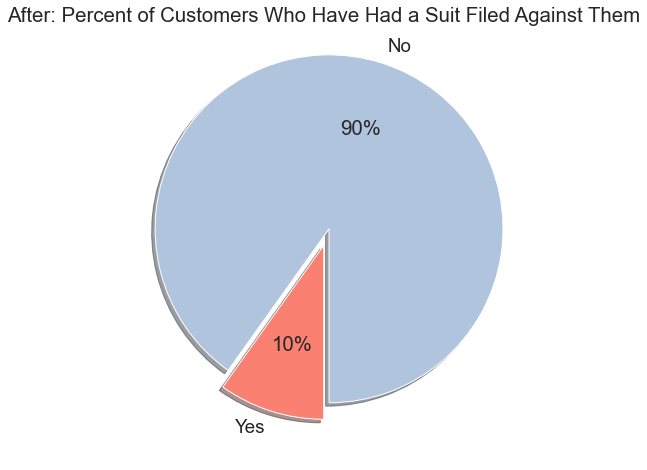

In [63]:
# Data to plot for the % of target variable
sns.set(font_scale = 1.7)
labels =fund_df['suitflag'].value_counts(sort = True).index
sizes = fund_df['suitflag'].value_counts(sort = True)
colors = ["lightsteelblue","salmon"]
explode = (0.1,0)  # explode 1st slice
 
rcParams['figure.figsize'] = 8,8
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=True, startangle=270,)
plt.title('After: Percent of Customers Who Have Had a Suit Filed Against Them')
plt.show()

In [64]:
fund_df

,tic,conm,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,SXI,STANDEX INTERNATIONAL CORP,Machinery,Industrial Machinary,No,D,1,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,26.33,4.47,31.46,0.05,22.28,0.95,0.26,0.56,7.15,6.28,50.24,40.43,2.12,21.06,7.94,0.69,8.37,0.01,0.01,0.00,-0.02,-0.11,0.00,0.00,-0.06,0.00,0.00,0.00,-0.10,-0.09,0.00,0.09,0.00,-3.24,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,BZLFY,BUNZL PLC,Trading Companies & Distributors,Trading Companies & Distributors,No,B,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,528.74,3.98,1073.88,132.24,197.78,14.75,0.87,1.62,68.68,11.29,1164.66,157.64,15.70,116.98,0.00,7.65,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10016,SWK,STANLEY BLACK & DECKER INC,Machinery,Industrial Machinary,No,D,1,0.00,0.00,-641.40,0.00,0.00,38.70,-0.39,0.00,-0.20,-3.80,-999.90,0.00,-36.30,11.70,84.60,-0.20,-194.20,-0.00,-0.00,572.43,90.24,738.29,8.89,415.92,38.61,5.77,1.71,290.82,135.86,1112.00,165.03,21.51,582.18,224.89,21.03,208.69,0.02,0.04,0.00,0.00,-0.10,0.00,0.00,0.10,0.01,0.00,-0.00,0.00,-0.11,0.00,-0.41,0.01,inf,-0.00,-0.08,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
10030,SCX,STARRETT (L.S.) CO -CL A,Machinery,Industrial Machinary,No,D,1,0.00,0.00,4.63,0.00,0.00,0.00,0.00,-0.75,-5.04,0.00,0.00,-0.68,-2.18,0.00,0.00,-0.50,2.59,-0.03,-0.04,21.36,1.76,17.38,0.06,15.22,0.67,0.10,0.62,4.14,2.51,24.15,12.42,3.13,15.18,0.00,0.30,7.44,0.02,0.03,0.00,0.00,0.04,0.00,0.00,0.00,0.00,1.67,1.69,0.00,0.00,-0.01,-2.54,0.00,0.00,-0.66,0.04,1.69,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
1004,AIR,AAR CORP,Aeorspace & Defense,Aerospace & Defense,No,D,1,-0.86,0.00,25.33,0.00,0.00,0.00,0.00,0.00,0.00,-5.22,29.33,0.00,-1.78,-16.24,0.00,-0.00,9.10,0.00,0.00,336.77,45.47,296.49,1.35,181.67,29.80,0.38,0.27,11.77,52.12,367.01,72.52,6.01,63.72,1.66,6.69,23.82,0.01,0.01,-0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.02,0.00,-0.05,-0.03,-0.00,0.00,0.05,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,SVT,SERVOTRONICS INC,Electrical Equipment,Electrical Components & Equipment,No,D,1,0.00,0.00,-2.40,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,-1.28,0.00,0.47,0.00,-1.03,-0.01,-0.28,0.00,0.00,0.84,0.48,1.30,0.07,1.58,0.03,0.02,0.54,1.05,0.41,1.78,1.08,0.28,1.53,0.66,0.01,0.31,0.04,0.05,0.00,0.00,-0.10,0.00,0.00,-0.14,0.00,0.00,0.00,0.00,-0.04,0.00,

In [65]:
fund_df.to_csv('../01_data/02_modified/company_data_cleaned.csv')

# Z-Score Conversion

In [66]:
fund_zscores = fund_df[fund_df.columns].drop(columns=['tic', 'conm'])

In [67]:
fund_zscores.head(2)

,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange,gla_PercentChange,dvt_PercentChange,invt_PercentChange,dte_PercentChange,revt_PercentChange,chech_PercentChange,do_PercentChange,exre_PercentChange
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10008,Machinery,Industrial Machinary,No,D,1,0.00,-0.13,-43.20,0.00,0.00,-0.89,0.00,-0.01,0.00,-9.25,-52.38,0.00,1.07,0.00,-2.39,0.00,-11.61,0.00,0.00,26.33,4.47,31.46,0.05,22.28,0.95,0.26,0.56,7.15,6.28,50.24,40.43,2.12,21.06,7.94,0.69,8.37,0.01,0.01,0.00,-0.02,-0.11,0.00,0.00,-0.06,0.00,0.00,0.00,-0.10,-0.09,0.00,0.09,0.00,-3.24,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100095,Trading Companies & Distributors,Trading Companies & Distributors,No,B,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,528.74,3.98,1073.88,132.24,197.78,14.75,0.87,1.62,68.68,11.29,1164.66,157.64,15.70,116.98,0.00,7.65,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [68]:
fund_zscores = fund_zscores.replace({np.inf:0, -np.inf:0, np.nan:0})

In [69]:
cols = list(fund_min_max.columns)
cols = cols + list(fund_std_values.columns)
# cols = cols + list(fund_most_recent.columns)
for col in cols:
    col_zscore = col
    fund_zscores[col] = abs((fund_zscores[col] - fund_zscores[col].mean())/fund_zscores[col].std(ddof=0))
    
fund_zscores.reset_index(inplace=True)

(-771.0435773845135, 85.06357738451345)

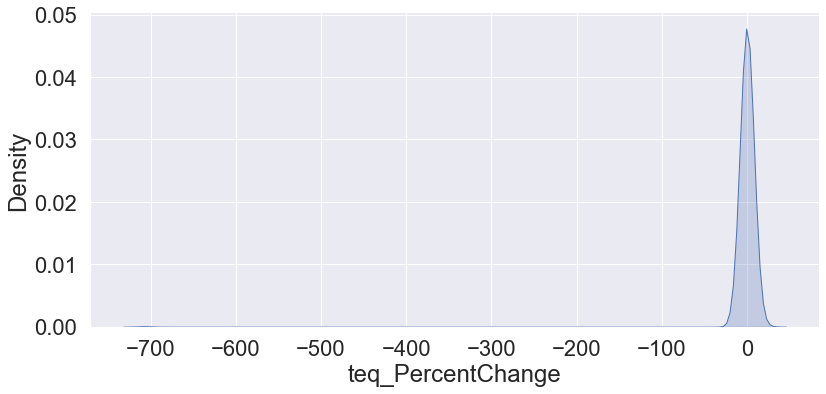

In [70]:
sns.set(font_scale = 2)
ax = sns.displot(fund_zscores, x='teq_PercentChange', kind='kde', height=6, aspect=2, fill=True, palette='dark')
plt.xlim()

In [71]:
fund_zscores.describe(percentiles=[.003, .01, .1, .25, .5, .75, .9, .95, .99, .997]).T.sort_values('max', ascending=False)

,count,mean,std,min,0.3%,1%,10%,25%,50%,75%,90%,95%,99%,99.7%,max
epspi_PercentChange,578.00,34.01,782.67,-2.50,-1.34,-0.53,0.00,0.00,0.00,0.00,0.00,0.40,18.79,201.02,18808.30
cogs_PercentChange,578.00,1.33,22.64,-0.95,-0.85,-0.38,-0.06,0.00,0.00,0.00,0.00,0.04,13.40,73.34,531.40
dltt_PercentChange,578.00,0.61,13.77,-0.97,-0.36,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.39,5.30,330.50
xsga_PercentChange,578.00,0.24,6.28,-0.65,-0.62,-0.45,-0.05,0.00,0.00,0.00,0.00,0.03,0.13,0.29,150.92
roe_PercentChange,578.00,-0.13,4.17,-95.97,-6.02,-1.14,0.00,0.00,-0.00,0.00,0.00,0.03,1.00,4.55,25.42
Vol_epspi_Variance,578.00,0.08,1.00,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.15,24.02
Vol_dltt_Variance,578.00,0.13,0.99,0.02,0.03,0.05,0.07,0.07,0.07,0.07,0.07,0.07,0.46,4.05,22.83
StdDev_xint,578.00,0.18,0.98,0.00,0.00,0.01,0.05,0.10,0.12,0.12,0.12,0.18,1.06,6.20,21.68
Vol_cogs_Variance,578.00,0.13,0.99,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.07,0.22,1.67,5.00,21.58
Vol_xint_Variance,578.00,0.12,0.99,0.01,0.01,0.03,0.05,0.05,0.05,0.05,0.06,0.07,0.39,4.28,21.46


In [72]:
fund_zscores.drop(columns=['gla_PercentChange', 'dvt_PercentChange', 'invt_PercentChange', 
                           'dte_PercentChange',  'revt_PercentChange',  'chech_PercentChange', 
                           'do_PercentChange', 'exre_PercentChange'], inplace=True)

# Outlier Detection

In [73]:
# #Outliers Methodology
def detect_outliers(df, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it greater than the 99.7% percentile, which is greater than 3 standard
    deviations from the mean. Once the outliers have been determined for one feature, their indices will be stored in 
    a list before proceeding to the next feature and the process repeats until the very last feature is completed. 
    Finally, using the list with outlier indices, we will count the frequencies of the index numbers and return them 
    if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        thresh = np.percentile(df[col], 99.7)
        outlier_step = thresh 
        outlier_list_col = df[(df[col] > thresh)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > 1) 
    return multiple_outliers


multiple_outliers = detect_outliers(fund_zscores, fund_zscores.select_dtypes('number').columns)
print("We will drop {} rows. The specific rows are in the list below ".format(len(multiple_outliers)), '\n')
print(detect_outliers(fund_zscores, fund_zscores.select_dtypes('number').columns))

fund_zscores.loc[multiple_outliers, :]

# # # Drop outliers and reset index
# print("Before: {} rows".format(len(fund_zscores)))
# fund_zscores = fund_zscores.drop(multiple_outliers, axis = 0).reset_index(drop = True)
# print("After: {} rows".format(len(fund_zscores)))

We will drop 17 rows. The specific rows are in the list below  

[206, 434, 452, 533, 384, 550, 260, 5, 303, 69, 479, 324, 461, 330, 292, 466, 245]


,gvkey,GIC_Industry,GIC_SubIndustry,suitflag,idbflag,restatementflag,Vol_at_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xido_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,Vol_roe_Variance,StdDev_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,StdDev_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,at_PercentChange,capx_PercentChange,cogs_PercentChange,cshfd_PercentChange,dltt_PercentChange,dp_PercentChange,emp_PercentChange,epspi_PercentChange,ni_PercentChange,ppent_PercentChange,sale_PercentChange,teq_PercentChange,txt_PercentChange,wcap_PercentChange,xido_PercentChange,xint_PercentChange,xsga_PercentChange,roa_PercentChange,roe_PercentChange
206,17812,Trading Companies & Distributors,Trading Companies & Distributors,No,D,1,17.93,6.93,4.21,1.91,3.33,7.55,0.05,0.04,15.17,0.47,4.55,4.50,5.74,8.09,0.92,10.33,7.03,0.00,1.77,1.20,0.19,2.63,0.38,2.29,2.83,1.79,0.90,2.21,0.31,2.95,0.64,0.03,1.62,0.02,2.68,4.26,0.10,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
434,5047,Industrial Congolomerates,Industrial Conglomerates,Yes,B,1,13.28,0.76,0.14,0.02,22.83,3.92,7.90,0.04,0.00,11.46,3.27,0.01,0.90,0.07,1.31,2.05,3.28,0.02,0.01,15.16,14.59,2.95,0.73,19.48,7.53,1.96,0.37,5.09,4.89,2.04,10.40,17.87,0.36,16.97,21.68,11.68,0.10,0.18,-0.01,0.00,0.00,0.00,0.15,-0.02,-0.05,0.00,0.00,-0.02,0.04,0.00,0.01,0.00,-0.62,-0.01,-0.02,0.01,0.00
452,5860,Machinery,Industrial Machinary,No,D,1,0.38,12.11,5.49,1.39,0.07,2.77,0.05,0.04,0.15,0.05,6.03,0.28,8.90,0.07,20.00,0.10,6.75,0.02,0.01,1.45,0.50,2.50,0.10,0.32,0.86,3.59,1.03,1.69,0.83,2.83,2.18,1.72,0.93,3.79,0.30,3.89,0.10,0.14,0.01,-0.61,-0.84,-0.50,0.02,-0.70,0.00,1.02,0.01,-0.01,-0.83,-0.01,-1.87,0.00,5.49,-0.03,-0.65,-0.01,0.02
533,6774,Aeorspace & Defense,Aerospace & Defense,Yes,D,1,0.08,15.29,0.19,0.02,0.07,1.27,0.05,0.04,1.18,0.08,0.11,1.37,0.47,0.93,0.52,0.05,0.03,0.02,0.02,0.39,0.14,0.59,0.03,0.30,0.42,1.49,0.12,0.40,0.09,0.27,2.79,0.95,0.40,2.47,0.02,0.28,0.10,4.90,0.00,0.31,-0.00,0.00,0.00,0.06,0.00,-0.02,-0.02,0.00,-0.00,-0.06,-0.01,-0.12,-0.06,0.00,0.00,-0.02,0.04
384,295786,Machinery,Construction & Farm Machinery & Heavy Trucks,No,B,1,0.03,0.02,21.58,0.02,6.01,21.26,0.05,0.04,13.35,0.08,21.24,0.01,19.03,0.07,0.09,21.46,19.80,0.02,0.01,11.00,9.29,12.86,3.43,10.31,11.54,9.80,0.26,1.73,11.35,13.00,3.54,2.59,0.36,0.18,5.81,11.68,0.10,0.17,0.00,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
550,7985,Aeorspace & Defense,Aerospace & Defense,No,D,1,0.05,11.10,4.82,0.02,0.13,3.04,21.24,0.04,0.00,20.69,4.39,0.78,2.74,9.38,3.32,0.25,2.89,0.02,0.01,0.80,1.07,3.58,0.02,0.56,1.70,5.82,0.10,0.01,2.55,3.08,2.09,1.39,2.72,0.11,0.15,1.54,0.10,0.17,-0.00,-0.24,-0.20,0.00,-0.03,-0.21,-0.32,0.00,0.00,-0.40,-0.19,-0.01,-0.17,1.47,8.93,-0.04,-0.20,0.00,0.01
260,184868,Aeorspace & Defense,Aerospace & Defense,No,D,1,0.03,0.02,0.03,0.16,0.07,0.33,0.05,0.42,0.00,0.50,0.02,0.43,0.03,0.19,0.09,0.05,0.03,0.02,0.55,0.13,0.12,0.25,0.12,0.04,0.03,0.18,0.13,0.31,0.04,0.24,0.23,0.19,0.23,0.18,0.04,0.25,0.10,0.15,0.00,0.00,-0.17,-1.00,0.00,2.33,0.00,18808.30,-0.00,0.50,0.00,-1.38,-0.00,-3.29,0.00,0.00,0.00,-0.00,-7.23
5,100424,Industrial Congolomerates,Industrial Conglomerates,No,B,1,0.03,0.02,0.02,0.02,0.07,0.02,0.05,0.04,0.42,0.08,0.02,0.10,0.06,18.06,0.09,0.05,0.06,0.02,0.01,2.55,2.75,3.12,0.11,0.60,2.17,9.41,0.85,4.47,9.27,2.86,6.53,0.10,7.92,0.18,0.04,2.64,0.10,0.17,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01
303,194355,Trading Companies & Distributors,Trading Companies & Distributors,No,D,1,0.03,0.02,0.02,0.72,0.07,0.03,0.05,0.04,0.04,0.08,0.02,0.00

<b>Action:</b> After reviewing the above outlier methodology, I have decided to cap any z-score greater than 3 to 3, as this will not remove any outliers from my dataset and keep as many suits as possible for the best potential results. Below is the code used to cap all numerical columns where the z-score is greater than 3.

In [74]:
cols = list(fund_zscores.select_dtypes('number').columns)
for ea in range(len(cols)):
    fund_zscores.loc[fund_zscores[cols[ea]]> 3, cols[ea]] = 3

In [75]:
y = len(fund_df[fund_df['suitflag']=='Yes']['suitflag'])
n = len(fund_df[fund_df['suitflag']=='No']['suitflag'])

print(y, ' / (', y, ' + ', n, ')', round((y / (y+n))*100,3), '% of the total population has had a suit file against them.' )

57  / ( 57  +  521 ) 9.862 % of the total population has had a suit file against them.


In [76]:
fund['suitflag'] = fund['suitflag'].replace({'Yes':1,'No':0})

In [77]:
fund_zscores.set_index('gvkey', inplace=True)

In [78]:
fund_zscores.describe(percentiles=[.003, .01, .1, .25, .5, .75, .9, .95, .99, .997]).T

,count,mean,std,min,0.3%,1%,10%,25%,50%,75%,90%,95%,99%,99.7%,max
restatementflag,578.00,0.92,0.28,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Vol_at_Variance,578.00,0.07,0.32,0.00,0.00,0.01,0.03,0.03,0.03,0.03,0.03,0.08,1.92,3.00,3.00
Vol_capx_Variance,578.00,0.08,0.32,0.00,0.00,0.01,0.02,0.02,0.02,0.02,0.03,0.23,1.54,3.00,3.00
Vol_cogs_Variance,578.00,0.08,0.32,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.07,0.22,1.67,3.00,3.00
Vol_cshfd_Variance,578.00,0.13,0.41,0.00,0.01,0.01,0.02,0.02,0.02,0.02,0.26,0.68,2.31,3.00,3.00
Vol_dltt_Variance,578.00,0.09,0.24,0.02,0.03,0.05,0.07,0.07,0.07,0.07,0.07,0.07,0.46,3.00,3.00
Vol_dp_Variance,578.00,0.10,0.36,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.10,0.37,2.56,3.00,3.00
Vol_emp_Variance,578.00,0.09,0.28,0.03,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,1.14,3.00,3.00
Vol_epspi_Variance,578.00,0.05,0.12,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.15,3.00
Vol_ni_Variance,578.00,0.07,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.15,2.36,3.00,3.00


In [79]:
# feature_num = list(enumerate(fund_zscores.columns[5:]))
# feature_num
# plt.figure(figsize = (25,400))
# sns.set(font_scale =1)

# for i in feature_num:
#     plt.subplot(30,3,i[0]+1)
#     sns.displot(data = fund_zscores,
#                 x = i[1],
#                 color='darkred',
#                 kind='kde',
#                 fill=True)

# #     plt.title(str(i[1]))
# #     plt.ylabel('Value')
# #     plt.xticks(rotation = 45)

(-0.5072557919986518, 3.5085834664759705)

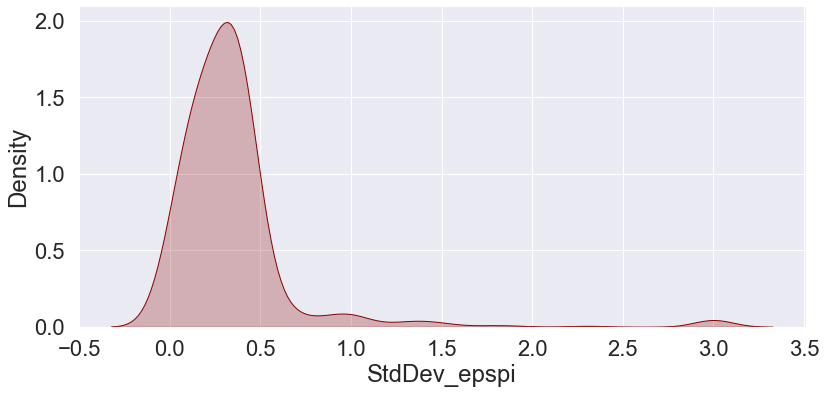

In [80]:
sns.set(font_scale = 2)
ax = sns.displot(fund_zscores, x='StdDev_epspi', kind='kde', height=6, aspect=2, fill=True, color='darkred')
plt.xlim()

# Export to 'Modified Folder' - Import File to Modeling Notebook (Part 2)

In [80]:
fund_zscores.to_csv('../01_data/02_modified/capstone_modeling_final1.csv', index=True)